# Exercise 07: EM algorithm for Gaussian Mixture Model

In this exercise we will implement M-step and E-step of EM algorithm for Gaussian Mixture Model. We will test it and visualize on two example sample.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

Data preparation (sample 1)

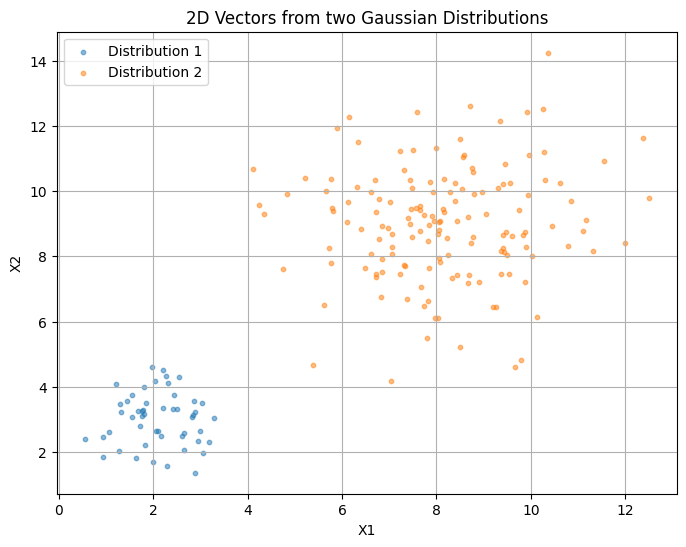

In [3]:
# Parameters for the Gaussian mixtures
mean_1 = [[2, 3], [8, 9]]
cov_1 = [ [[0.5, 0], [0, 0.5]], [[3, 0], [0, 3]] ]  


# Generate samples from each distribution
x_1_1 = np.random.multivariate_normal(mean_1[0], cov_1[0], 50)
x_1_2 = np.random.multivariate_normal(mean_1[1], cov_1[1], 150)

# Combine the samples
x_1 = np.vstack((x_1_1, x_1_2))

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(x_1_1[:, 0], x_1_1[:, 1], alpha=0.5, label='Distribution 1', s=10)
plt.scatter(x_1_2[:, 0], x_1_2[:, 1], alpha=0.5, label='Distribution 2', s=10)
plt.title("2D Vectors from two Gaussian Distributions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

Data preparation (sample 2)

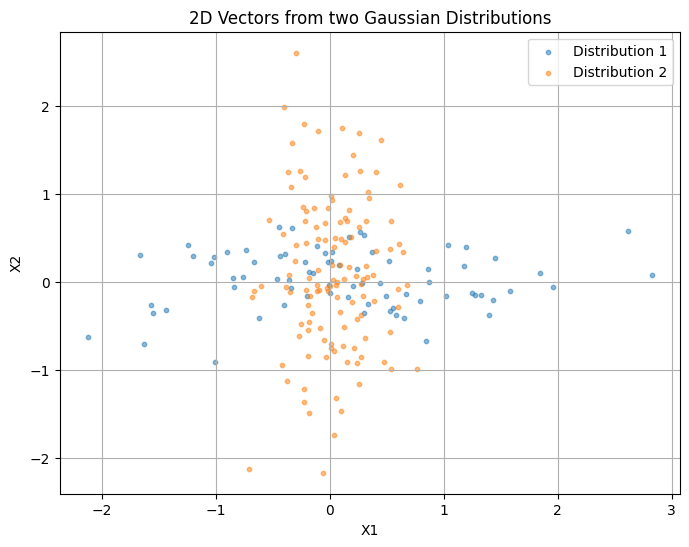

In [4]:
# Parameters for the Gaussian mixtures
mean_2 = [[0, 0], [0, 0]]
cov_2 = [
    [[1, 0], [0, 0.1]],  # Elongated along X-axis
    [[0.1, 0], [0, 1]],  # Elongated along Y-axis
] 


# Generate samples from each distribution
x_2_1 = np.random.multivariate_normal(mean_2[0], cov_2[0], 75)
x_2_2 = np.random.multivariate_normal(mean_2[1], cov_2[1], 125)

# Combine the samples
x_2 = np.vstack((x_2_1, x_2_2))

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(x_2_1[:, 0], x_2_1[:, 1], alpha=0.5, label='Distribution 1', s=10)
plt.scatter(x_2_2[:, 0], x_2_2[:, 1], alpha=0.5, label='Distribution 2', s=10)
plt.title("2D Vectors from two Gaussian Distributions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

Utility functions

In [6]:

def multivariate_normal_pdf_array(x, mean, cov):
    """
    Calculate the multivariate normal PDF for an array of points.
    
    Parameters:
    - x: ndarray
        Array of points at which to evaluate the PDF (shape: (..., dim)).
    - mean: ndarray
        The mean of the multivariate normal distribution (1D array).
    - cov: ndarray
        The covariance matrix of the multivariate normal distribution (2D square array).
        
    Returns:
    - ndarray
        Array of the same shape as the input, containing the PDF values.
    """
    n = mean.shape[0]

    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm = 1 / np.sqrt((2 * np.pi) ** n * det_cov)

    difference = x - mean
    exponent = -0.5 * np.sum(difference @ inv_cov * difference, axis=-1)

    return norm * np.exp(exponent)



# Function to plot multiple ellipses for a single bivariate normal distribution
def plot_ellipses(ax, mean, cov, color, label, levels=[1, 2, 3]):
    """
    Add multiple ellipses corresponding to different levels of standard deviations.
    
    Parameters:
    - ax: Matplotlib axis to plot on.
    - mean: Mean of the distribution (center of the ellipse).
    - cov: Covariance matrix.
    - color: Color of the ellipse.
    - label: Label for the plot.
    - levels: List of standard deviation levels to plot.
    """
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    for level in levels:
        width, height = 2 * level * np.sqrt(eigenvalues)  # Scale by standard deviation level
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor='none', lw=2, alpha=0.5
                                             )
        ax.add_patch(ellipse)



#scatter plot with cluster assignment
def scatter_cluster(x, w, all_means, all_covariances, threshold = 0.5):
    # Assign categories based on probabilities

    probs = w[0]
    
    categories = probs > threshold  # True for category 1, False for category 0

    # Scatter plot with different colors for categories

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x[categories, 0], x[categories, 1], label="Cluster 1", alpha=0.7, color='red')
    plt.scatter(x[~categories, 0], x[~categories, 1], label="Cluster 0", alpha=0.7, color='blue')
    plt.title("Scatterplot with Two Clusters")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

    all_colors = ['red', 'blue']

    for mean, cov, color in zip(all_means, all_covariances, all_colors):
        plot_ellipses(ax, mean, cov, color, f'Bivariate Normal (mean={mean})', levels=[1, 2, 3])


    plt.show()



Define E-step

In [7]:
def e_step(x, mean, cov, pi):
    """
    Calculate the value of Q-function and matrix W of cluster membership probabilities (see page 360 in lecture)
    
    Parameters:
    - x: ndarray
        Array of points in sample.
    - mean: ndarray
        The mean of the multivariate normal distribution (1D array).
    - cov: ndarray
        The covariance matrix of the multivariate normal distribution (2D square array).
    - pi: ndarray
        The vector of mixing weights (see page 353 in lecture)
        
    Returns:
    - Q: float
        Value of Q-function
    - w: ndarray
        matrix W of cluster membership probabilities
    """
    n_samples, n_components = x.shape[0], mean.shape[0]
    w = np.zeros((n_samples, n_components))
    for k in range (n_components):
        w[:, k] = pi[k] * multivariate_normal_pdf_array(x, mean[k], cov[k])
    w /= w.sum(axis=1, keepdims=True)
    return w

Define M-step

In [ ]:
def m_step(x, w, mean, cov):
    """
    Calculates the updated values of mean, covariance and pi in GMM (see page 362 in lecture)
    
    Parameters:
    - x: ndarray
        Array of points in sample.
    - w: ndarray
        matrix W of cluster membership probabilities
    - mean: ndarray
        The mean of the multivariate normal distribution (1D array).
    - cov: ndarray
        The covariance matrix of the multivariate normal distribution (2D square array).
        
    Returns:
    - mean_new: ndarray
        The updated mean of the multivariate normal distribution (1D array).
    - cov_new: ndarray
        The updated covariance matrix of the multivariate normal distribution (2D square array).
    - pi_new: ndarray
        The updated vector of mixing weights.
    """
    n_samples, n_features = x.shape
    n_components = w.shape[0]

    nk = w.sum(axis=0)
    new_weights = nk / n_samples

    new_means = (w.T @ x) / nk[:, np.newaxis]

    new_covs = np.zeros((n_components, n_features, n_features))
    for k in range(n_components):
        difference = x - new_means[k]
        w_diff = difference.T @ w[:, np.newaxis]
        new_covs[k] = w_diff / nk[k]
    return new_weights, new_means, new_covs


Run EM algorithm for sample 1

Iteration   1: Q=-8389.358567807096, pi=[0.97964716 0.02035284], mean=[[6.46385015 7.67274772]
 [1.49232044 2.3212728 ]]


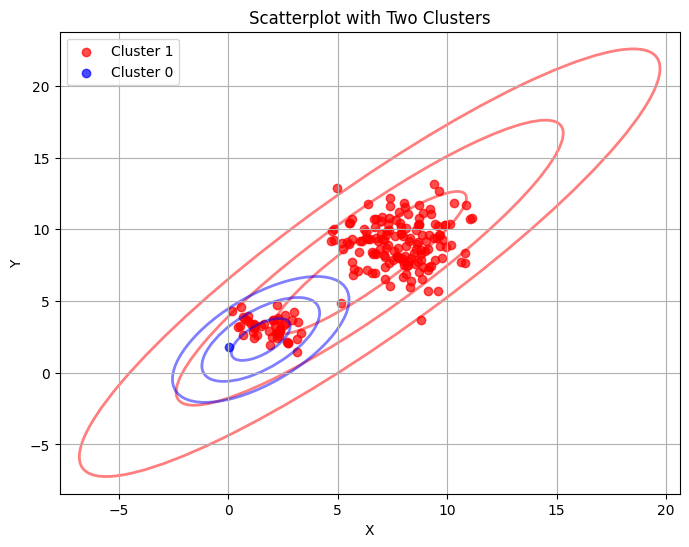

Iteration   2: Q=-960.9837774259827, pi=[0.97046786 0.02953214], mean=[[6.50140597 7.70234173]
 [1.80345438 3.01213913]]


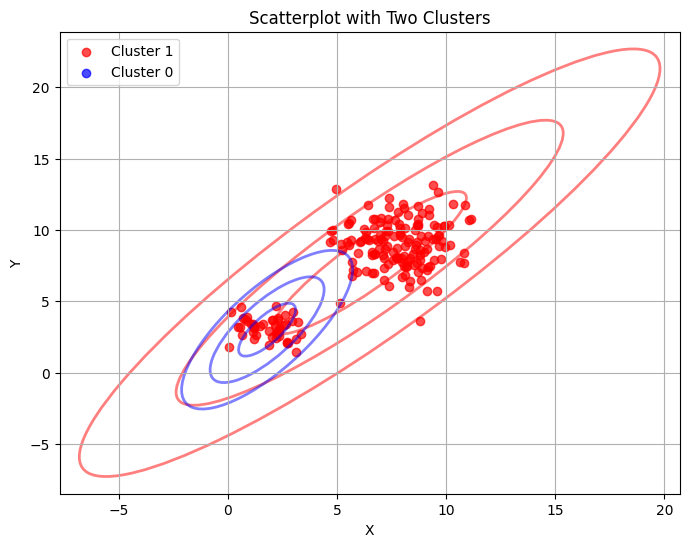

Iteration   3: Q=-964.636397786331, pi=[0.95897989 0.04102011], mean=[[6.55760266 7.75217143]
 [1.80536621 3.16073008]]


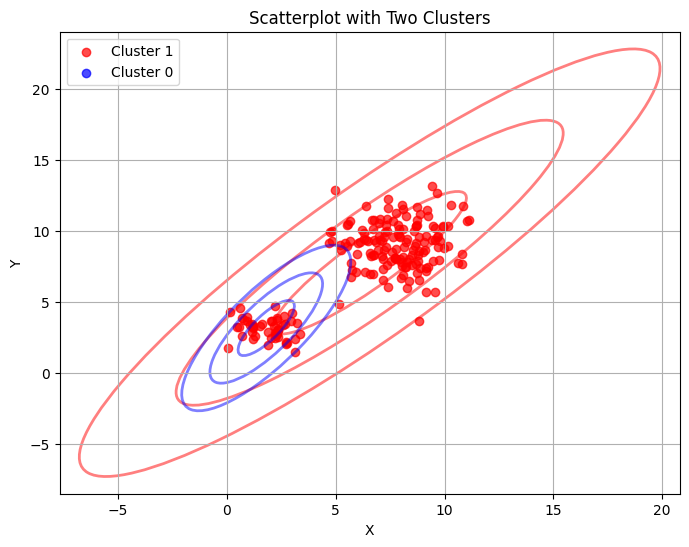

Iteration   4: Q=-967.6099155692627, pi=[0.9467603 0.0532397], mean=[[6.62013629 7.80884031]
 [1.78406722 3.206818  ]]


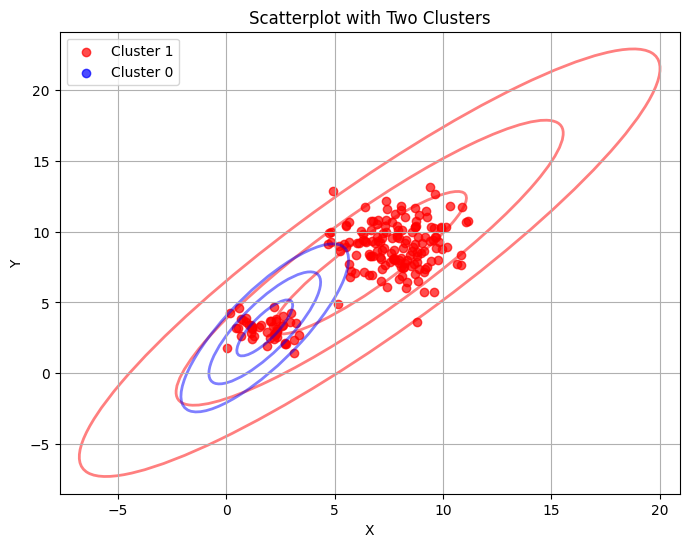

Iteration   5: Q=-969.9446804169359, pi=[0.93494798 0.06505202], mean=[[6.68235662 7.86535095]
 [1.76796349 3.23027692]]


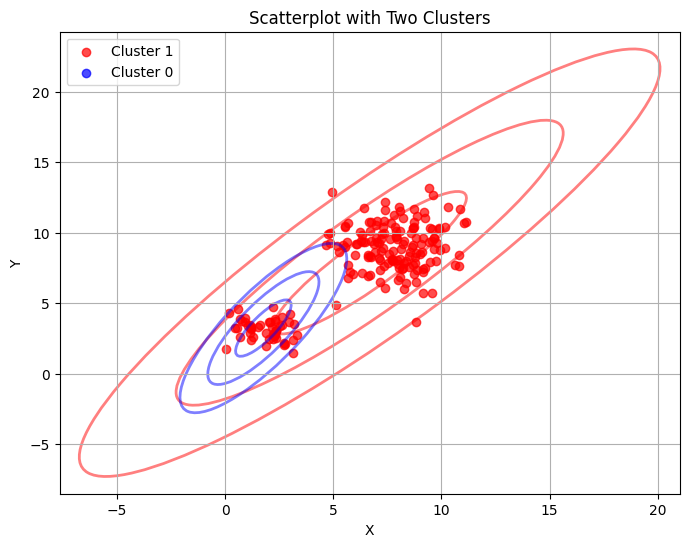

Iteration   6: Q=-971.7747695647327, pi=[0.92450065 0.07549935], mean=[[6.73873655 7.91646763]
 [1.75761929 3.24573078]]


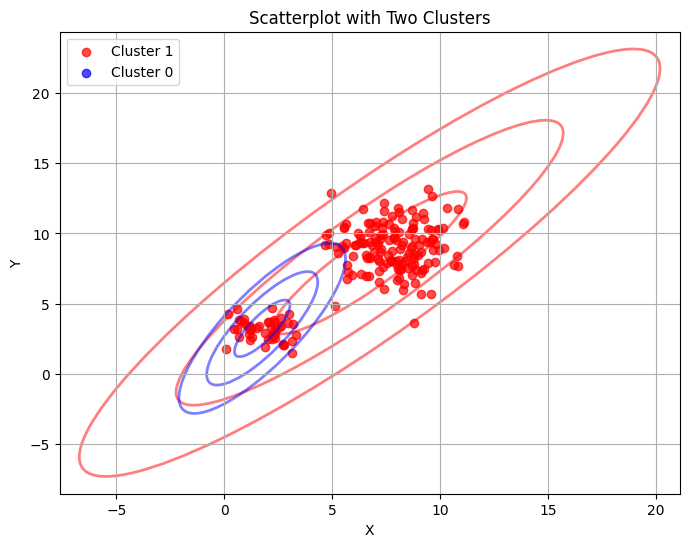

Iteration   7: Q=-973.2112481103447, pi=[0.91589731 0.08410269], mean=[[6.78607483 7.95926628]
 [1.7516411  3.25743964]]


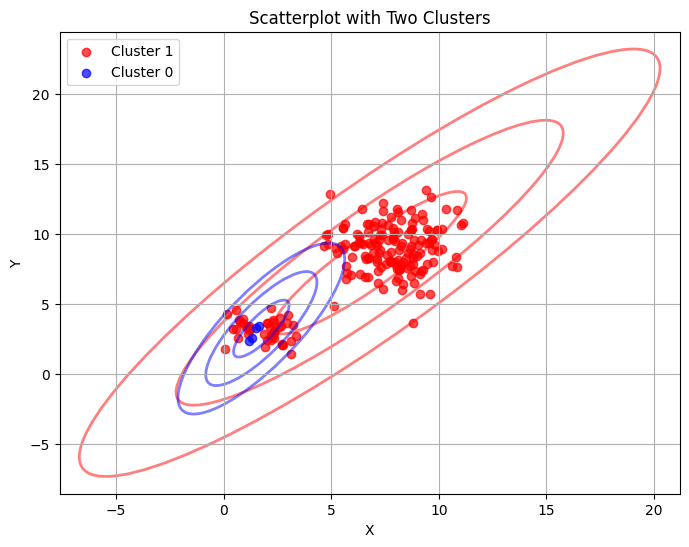

Iteration   8: Q=-974.3369548310355, pi=[0.90918428 0.09081572], mean=[[6.82353616 7.99303544]
 [1.74874595 3.26692191]]


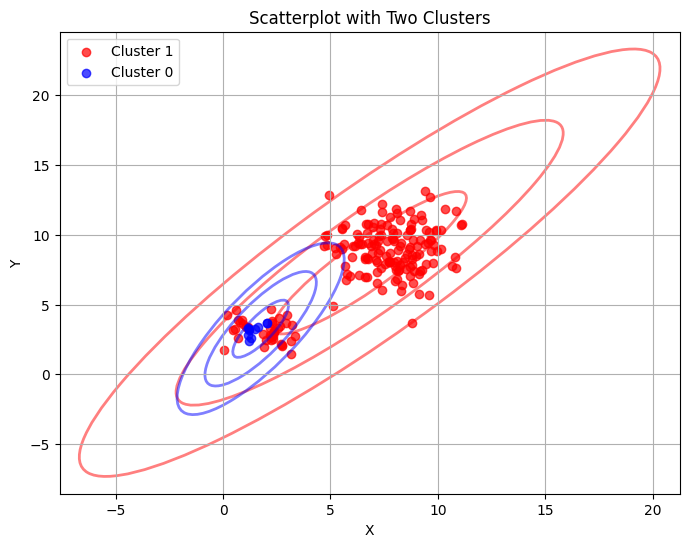

Iteration   9: Q=-975.2124463789186, pi=[0.9041545 0.0958455], mean=[[6.85185707 8.01849466]
 [1.74789664 3.27477028]]


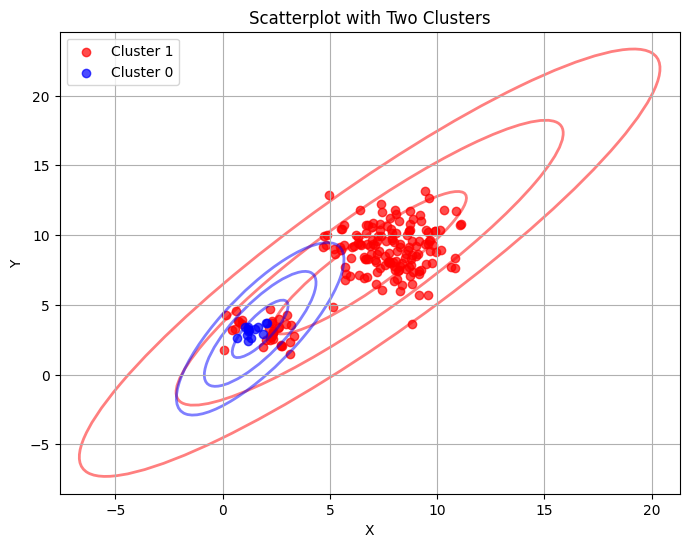

Iteration  10: Q=-975.8849963847078, pi=[0.90050312 0.09949688], mean=[[6.8725083  8.03701112]
 [1.74829835 3.28127281]]


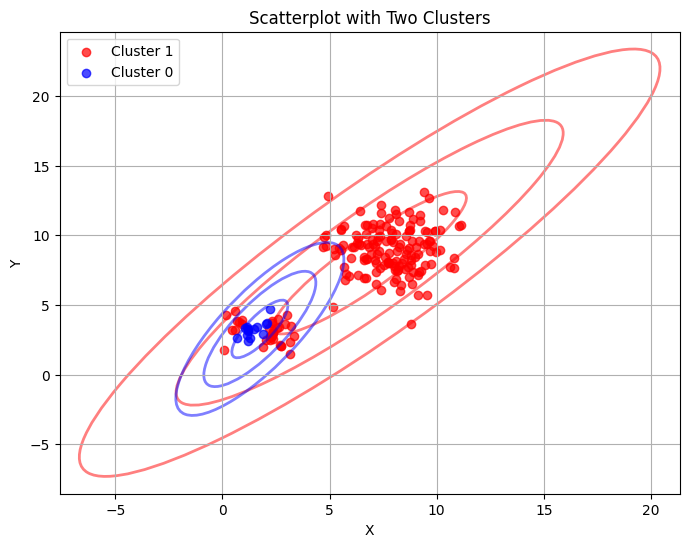

In [30]:
#initialization (you can play with initial parameters)
mean_it = [[1, 2], [0, 1]]
cov_it = [ [[1, 0], [0, 1]], [[1, 0], [0, 0.5]] ] 
pi_it = [0.2,0.8]

for it in range(10):
    Q, w = e_step(x_1, mean_it, cov_it, pi_it)
    pi_it,  mean_it, cov_it = m_step(x_1, w, mean_it, cov_it)
    print(f"Iteration {it+1:3d}: Q={Q}, pi={pi_it}, mean={mean_it}")
    scatter_cluster(x_1, w, mean_it, cov_it)

Run EM algorithm for sample 2

Iteration   1: Q=-755.6140660014901, pi=[0.07085879 0.92914121], mean=[[ 0.42634526  0.07326016]
 [-0.06246164 -0.00583249]]


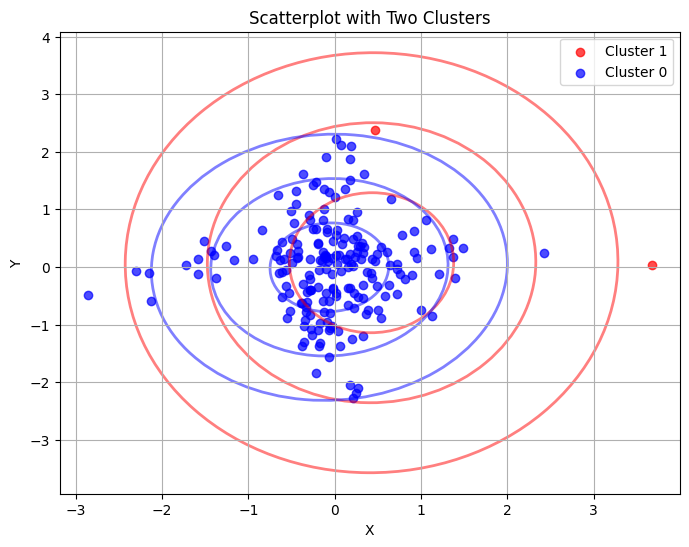

Iteration   2: Q=-498.02309605554035, pi=[0.07105846 0.92894154], mean=[[ 0.45027149  0.11511451]
 [-0.06439693 -0.0090511 ]]


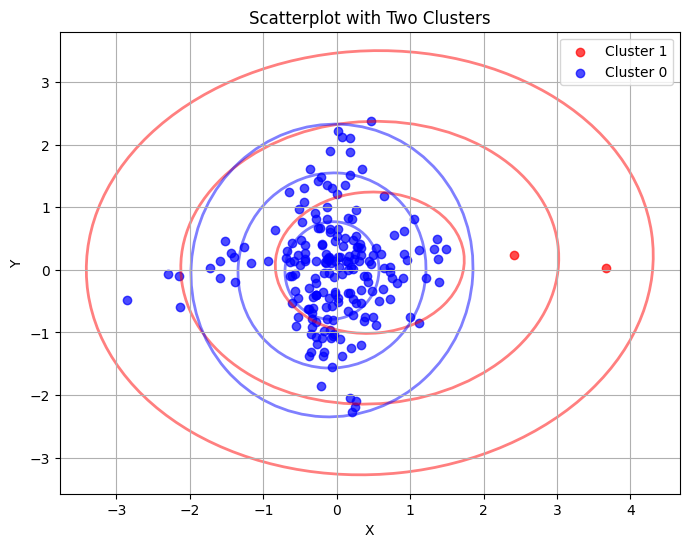

Iteration   3: Q=-488.6160610608592, pi=[0.07254903 0.92745097], mean=[[ 0.13245034  0.08682908]
 [-0.04036281 -0.00703805]]


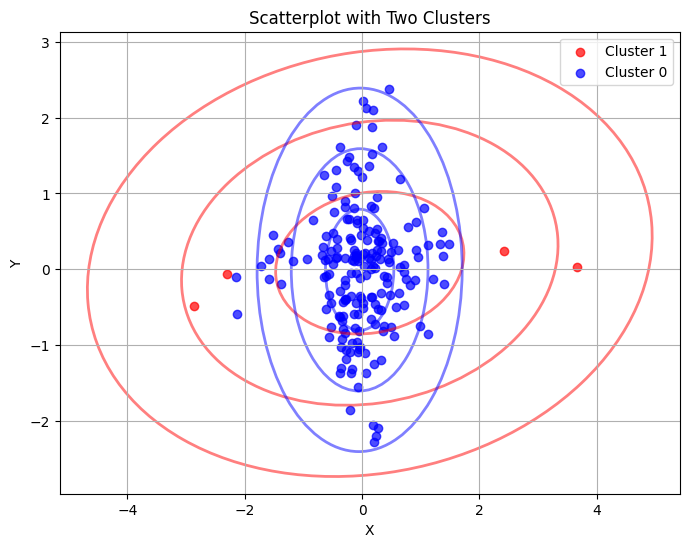

Iteration   4: Q=-478.7842410395271, pi=[0.07990415 0.92009585], mean=[[-0.18373304  0.03083308]
 [-0.01428585 -0.00292554]]


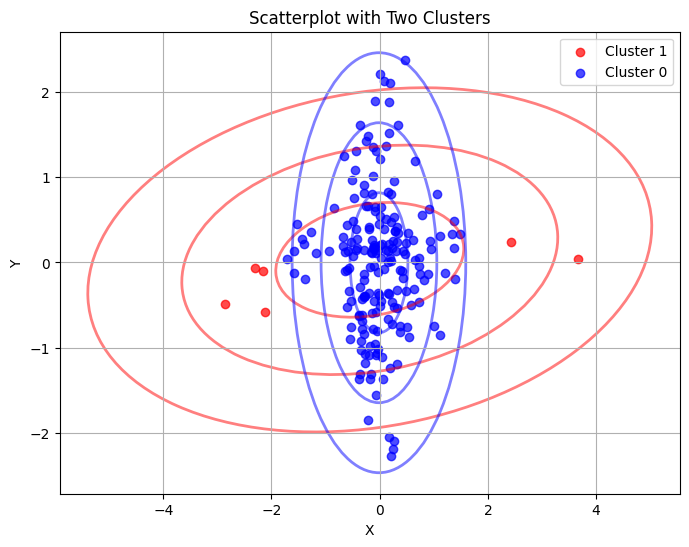

Iteration   5: Q=-471.8672725799638, pi=[0.09635604 0.90364396], mean=[[-0.30166921  0.01487011]
 [ 0.00137473 -0.00183801]]


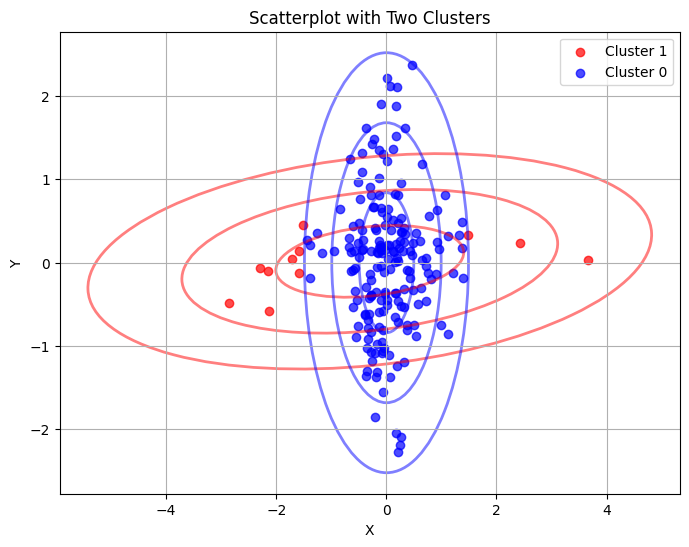

Iteration   6: Q=-465.6457110123363, pi=[0.12389054 0.87610946], mean=[[-0.28391315  0.04054191]
 [ 0.00838797 -0.00599336]]


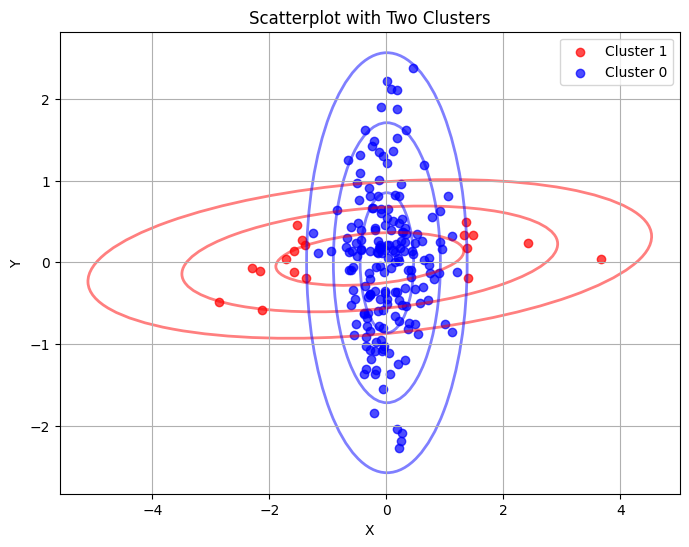

Iteration   7: Q=-461.30208298373924, pi=[0.15539695 0.84460305], mean=[[-0.22366804  0.06780617]
 [ 0.00820735 -0.01274558]]


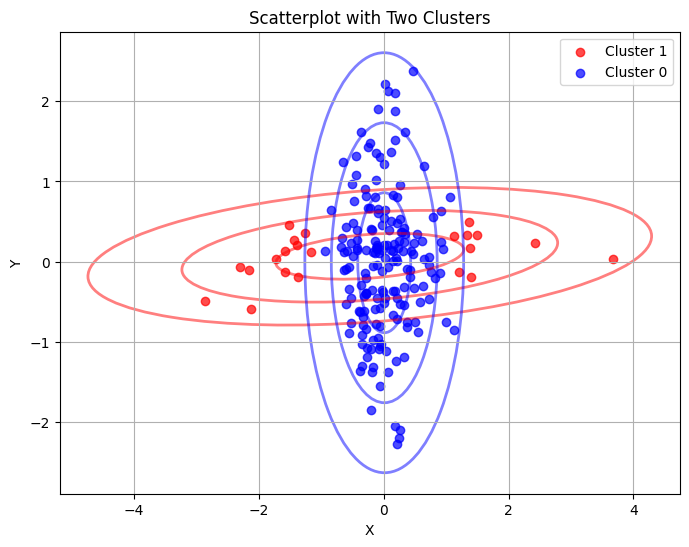

Iteration   8: Q=-459.7508015498145, pi=[0.18462477 0.81537523], mean=[[-0.17077305  0.08480668]
 [ 0.00454215 -0.01948244]]


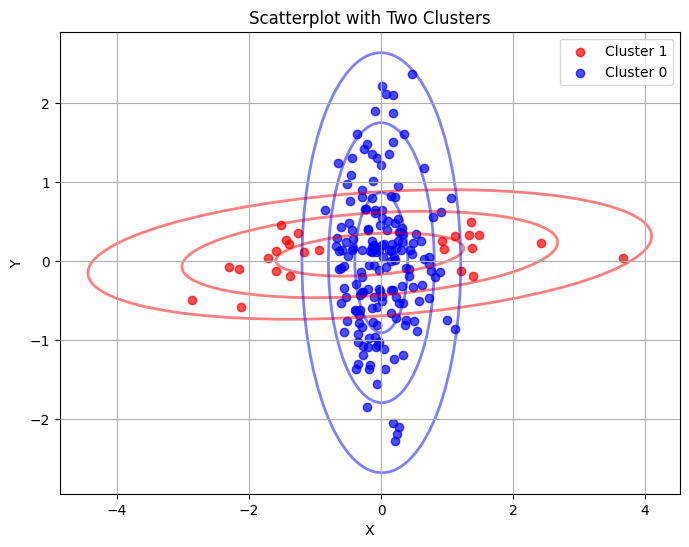

Iteration   9: Q=-460.2973174908074, pi=[0.20877675 0.79122325], mean=[[-0.1344866   0.09456801]
 [ 0.00031887 -0.02524153]]


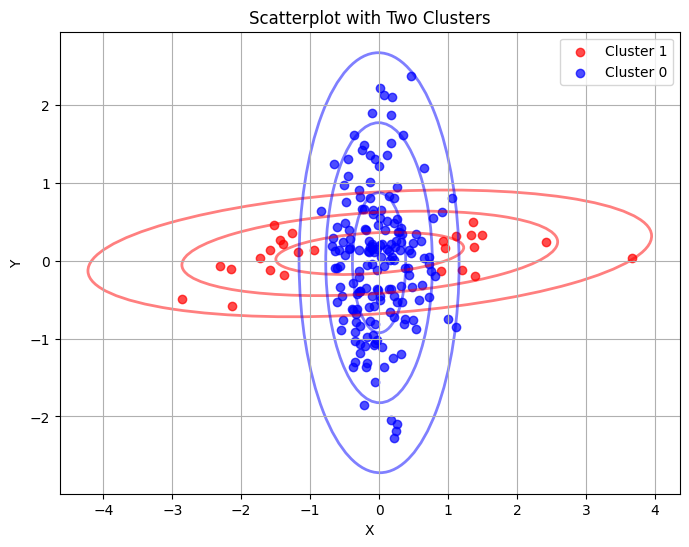

Iteration  10: Q=-461.68412318897356, pi=[0.2276662 0.7723338], mean=[[-0.11064286  0.10052523]
 [-0.0034127  -0.02992784]]


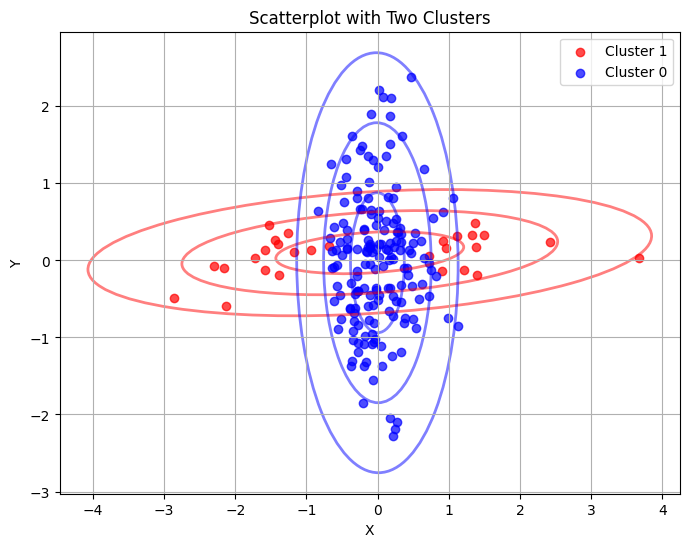

In [31]:
#initialization (you can play with initial parameters)
mean_it = [[1, 2], [0, 1]]
cov_it = [ [[1, 0], [0, 1]], [[1, 0], [0, 0.5]] ] 
pi_it = [0.2,0.8]

for it in range(10):
    Q, w = e_step(x_2, mean_it, cov_it, pi_it)
    pi_it,  mean_it, cov_it = m_step(x_2, w, mean_it, cov_it)
    print(f"Iteration {it+1:3d}: Q={Q}, pi={pi_it}, mean={mean_it}")
    scatter_cluster(x_2, w, mean_it, cov_it)